**MLP : метод обратного распространения ошибки**

три обрабатывающих слоя,  
потеря - кросс-энтропия

классификация набора MNIST (картинки с цифрами)

Евгений Борисов borisov.e@solarl.ru

---

## библиотеки

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
    
from sklearn.datasets import fetch_openml
import pickle

import os 
import gzip

In [2]:
# размер скрытого слоя
s_layer1 = 100
s_layer2 = 50

##  загружаем данные 

In [3]:
# процедура загрузки данных из хранилища sklearn.datasets.fetch_openml 
# определена для sklearn версии >= 0.20.0

# файл mnist.pkl.gz с набором MNIST 
# так же можно загрузить по следующей ссылке
#     https://yadi.sk/d/QW7_jM3aZASxNQ

from sklearn import __version__ as SKLEARN_VERSION
print(SKLEARN_VERSION)

0.23.2


In [4]:
f_mnist='mnist.pkl.gz'

if os.path.isfile(f_mnist):
    with gzip.open(f_mnist,'rb')  as f: mnist = pickle.load(f)
else:
    print('load from openml.org...')
    # Load data from https://www.openml.org/d/554
    mnist = fetch_openml('mnist_784', cache=False)
    with gzip.open(f_mnist,'wb')  as f: pickle.dump( mnist, f )


load from openml.org...


In [5]:
# mnist.keys() 
# ['data', 'target', 'feature_names', 'DESCR', 'details', 'categories', 'url']

In [6]:
X = mnist['data']
y = OneHotEncoder(sparse=False,categories='auto').fit_transform(mnist['target'].reshape(-1, 1))

X.shape, y.shape

((70000, 784), (70000, 10))

---

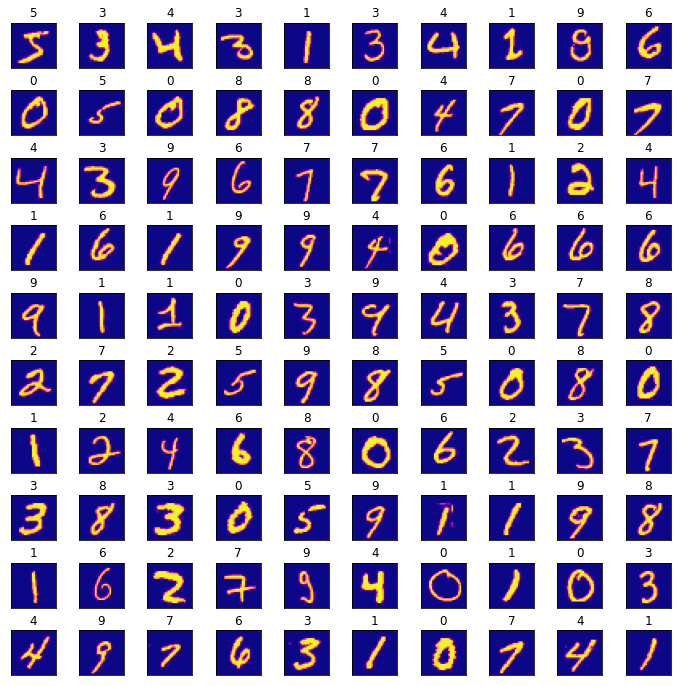

In [7]:
X_plot = mnist['data'].reshape(mnist['data'].shape[0],28,28)
y_plot = mnist['target']

m=10

f, axarr = plt.subplots( m, m, figsize=(m*1.2,m*1.2))

k=0
for j in range(m):
    for i in range(m):
        k=m*j+i 
        axarr[i][j].set_title(y_plot[k])
        axarr[i][j].axes.get_xaxis().set_visible(False)
        axarr[i][j].axes.get_yaxis().set_visible(False)
        axarr[i][j].imshow(X_plot[k,:,:],cmap=plt.cm.plasma)

# plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.5, wspace=0.35)
plt.subplots_adjust( hspace=0.5, wspace=0.25)
plt.show()

---

In [8]:
# нормируем данные
X = MinMaxScaler([0.0,1.0]).fit_transform(X)

In [9]:
# разделяем на  учебный, тестовый, контрольный
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.91)
X_train, X_val, y_train, y_val = train_test_split( X_train, y_train, test_size=0.5)

X_train.shape[0], X_test.shape[0], X_val.shape[0]

(3150, 63700, 3150)

In [10]:
%xdel mnist
%xdel X_plot
%xdel y_plot
%xdel X
%xdel y

##  ф-ции активации слоёв

In [11]:
# ф-ции активации скрытых слоёв и её производная 
def relu(s): return np.maximum( 0.0, s )
def relu_drv(s): return (s>0.0).astype(float)

# def lrelu(z): return np.log(1.0+np.exp(z))
# def lrelu_drv(z): return np.exp(z)/(np.exp(z)+1.0);

# def sigm(z): return np.tanh(z)
# def sigm_drv(z): return 1.0/(np.cosh(z)**2)

In [12]:
act1 = relu
act1_drv = relu_drv

act2 = relu
act2_drv = relu_drv

In [13]:
# ф-ция активации выходного слоя и её производная 
def softmax(s): 
    e = np.exp(s)
    return e / e.sum(axis=1).reshape(s.shape[0],1)

def softmax_drv(z): return 1.0 

In [14]:
act3 = softmax
act3_drv = softmax_drv

In [15]:
# функция потери - средняя кросс-энтропия
def cross_entr(o,y):
    o_restr = np.minimum(0.99999,np.maximum(1e-9,o))
    return -( y*np.log(o_restr) + (1-y)*np.log(1.0-o_restr) ).sum() / y.shape[0]    

In [16]:
loss = cross_entr 

---

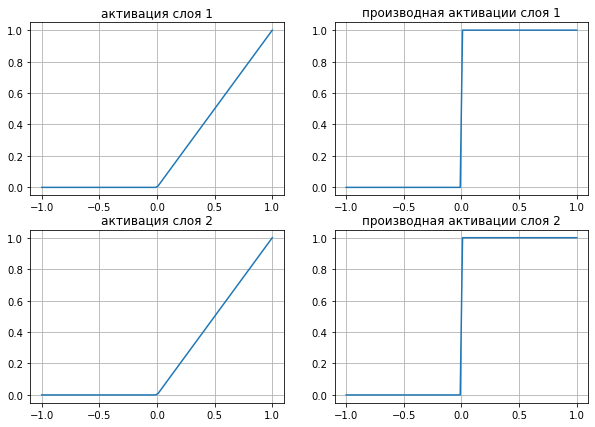

In [17]:
jj = np.linspace(-1.0,1.0,100)

f, axarr = plt.subplots(2,2, sharey=False, sharex=False, figsize=(10,7),)
    
axarr[0,0].set_title('активация слоя 1')
axarr[0,0].plot( jj, act1(jj) )
axarr[0,0].grid()

axarr[0,1].set_title('производная активации слоя 1')
axarr[0,1].plot( jj, act1_drv(jj) )
axarr[0,1].grid()

axarr[1,0].set_title('активация слоя 2')
axarr[1,0].plot( jj, act2(jj) )
axarr[1,0].grid()

axarr[1,1].set_title('производная активации слоя 2')
axarr[1,1].plot( jj, act2_drv(jj) )
axarr[1,1].grid()

plt.show()

##  метод обратного распространения 

In [18]:
# выход
def run(x): 
    return act3( act2( act1( x.dot(W1) + S1 ).dot(W2) + S2 ).dot(W3) + S3 ) # выход сети

In [19]:
# прямой проход, состояния слоёв
def forward(x):
    L = [ x.dot(W1) + S1 ] # состояние (не активированное) скрытого слоя
    L.append( act1(L[-1]).dot(W2) + S2 ) # состояние (не активированное) скрытого слоя
    L.append( act2(L[-1]).dot(W3) + S3 ) # состояние (не активированное) выходного слоя
    return L

In [20]:
# обратный проход
def backward(L,y):
    E = [ act3(L[2])-y ] # ошибка выходного слоя
    E.append( E[-1].dot(W3.T)*act2_drv(L[1]) ) # ошибка скрытого слоя
    E.append( E[-1].dot(W2.T)*act1_drv(L[0]) ) # ошибка скрытого слоя
    return E[::-1]

In [21]:
# L = forward(X)  # прямой проход 
# E = backward(L) # обратный проход 

In [22]:
# градиент
def grad(X,L,E):
    GW = [ X.T.dot(E[0]) ] # градиент по весам скрытого слоя
    GS = [ E[0].sum(axis=0) ] # градиент по сдвигам скрытого слоя

    O1 = act1(L[0]) # выход скрытого слоя
    GW.append( O1.T.dot(E[1]) ) # градиент по весам выходного слоя
    GS.append( E[1].sum(axis=0) ) # градиент по сдвигам выходного слоя

    O2 = act2(L[1]) # выход скрытого слоя
    GW.append( O2.T.dot(E[2]) ) # градиент по весам выходного слоя
    GS.append( E[2].sum(axis=0) ) # градиент по сдвигам выходного слоя

    return GW,GS

In [23]:
# L = forward(X) # прямой проход
# E = backward(L) # обратный проход
# G = grad(L,E)

In [24]:
# нормируем градиент
def grad_norm(gw,gs):
    mw = np.abs(np.hstack([ gw[0].flatten(), 
                            gw[1].flatten(), 
                            gw[2].flatten(), 
                            gs[0], 
                            gs[1], 
                            gs[2], 
                          ]) ).max()

    if (mw != 0):
        gw[0], gw[1], gw[2] = gw[0]/mw, gw[1]/mw, gw[2]/mw, 
        gs[0], gs[1], gs[2] = gs[0]/mw, gs[1]/mw, gs[2]/mw

    return gw,gs

## обучение сети

In [25]:
# инициализация весов и сдвигов
W1 = np.random.normal( loc=0.0, scale=0.01, size = [X_train.shape[1], s_layer1] )  
S1 = np.zeros(s_layer1)

W2 = np.random.normal( loc=0.0, scale=0.01, size = [s_layer1, s_layer2 ] ) 
S2 = np.zeros(s_layer2)

W3 = np.random.normal( loc=0.0, scale=0.01, size = [s_layer2, y_train.shape[1] ] ) 
S3 = np.zeros(y_train.shape[1])

In [26]:
# метод градиентного спуска

a = 0.06 # скорость обучения
m = 0.9  # параметр момента
r = 0.001  # параметр регуляризации

# максимальное число циклов обучения
MAX_ITER = 100

MIN_ERROR = 0.7 # порог минимальной ошибки

err = [ 1e7 ] # история ошибки

# измение весов на пред.шаге для применения моментов
dW1,dW2,dW3 = 0.0, 0.0, 0.0 
dS1,dS2,dS3 = 0.0, 0.0, 0.0

In [27]:
%%time

for i in range(MAX_ITER):
    E = loss(run(X_val),y_val)

    assert ~np.isnan(E)

    err.append(E) # история значений ф-ции потери

    # print( i+1, ':', err[-1] )

    if err[-1] < MIN_ERROR: # проверяем достижение порога
        print('порог ошибки достигнут')
        break

    L = forward(X_train) # прямой проход
    E = backward(L,y_train) # обратный проход

    GW,GS = grad(X_train,L,E) # градиент
    GW,GS = grad_norm(GW,GS) # нормируем градиент

    # измение весов
    dW1 = a*( GW[0] + r*W1 ) + m*dW1
    dW2 = a*( GW[1] + r*W2 ) + m*dW2 
    dW3 = a*( GW[2] + r*W3 ) + m*dW3
    dS1 = a*GS[0] + m*dS1
    dS2 = a*GS[1] + m*dS2
    dS3 = a*GS[2] + m*dS3

    # корректируем веса
    W1 = W1 - dW1 
    W2 = W2 - dW2 
    W3 = W3 - dW3 
    S1 = S1 - dS1
    S2 = S2 - dS2
    S3 = S3 - dS3 

print('step:',i+1,'/',MAX_ITER)
print('error:',err[-1],'/',MIN_ERROR)

порог ошибки достигнут
step: 57 / 100
error: 0.6533433600163535 / 0.7
CPU times: user 27.8 s, sys: 0 ns, total: 27.8 s
Wall time: 27.8 s


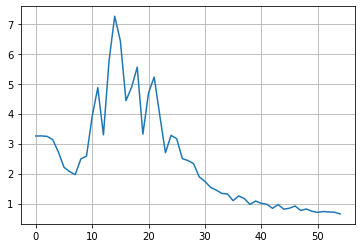

In [28]:
# изменение ошибки обучения
fig, ax = plt.subplots()
ax.plot(err[3:])
plt.grid()
plt.show()

##  результаты

In [29]:
p = run(X_test) 
loss(p,y_test)

0.6650013721903135

In [30]:
y_t = np.argmax(y_test,axis=1) 
y_o = np.argmax(p,axis=1)

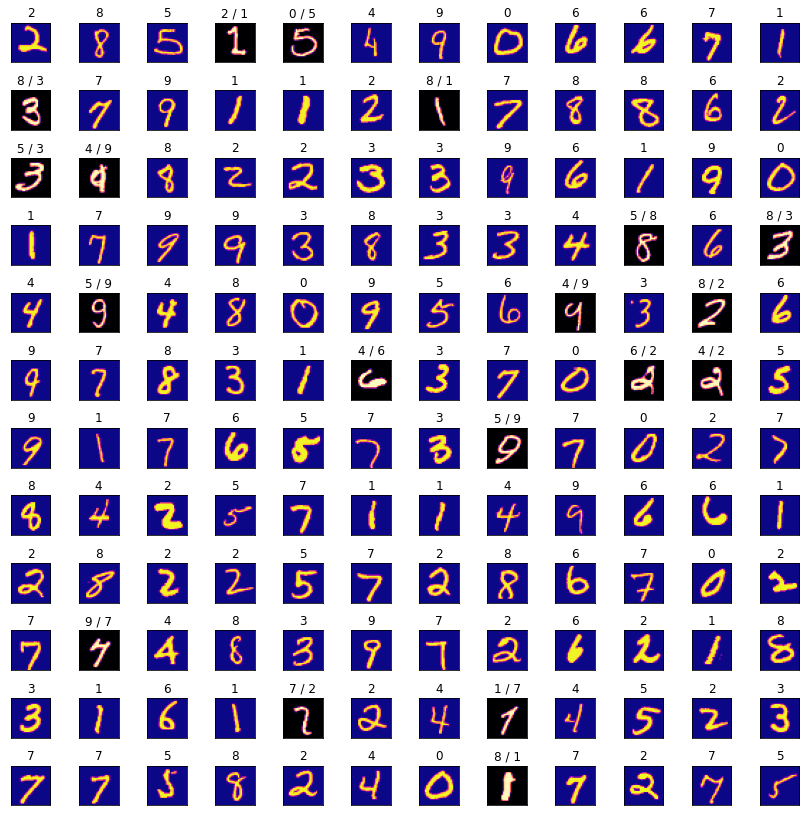

In [31]:
X_plot = X_test.reshape(X_test.shape[0],28,28)

m=12

f, axarr = plt.subplots( m, m, figsize=(m*1.2,m*1.2))

k=0
for j in range(m):
    for i in range(m):
        k=m*j+i 
        er = y_t[k]==y_o[k]
        axarr[i][j].set_title( '%i'%y_o[k] if er else '%i / %i'%(y_o[k],y_t[k]) )
        axarr[i][j].axes.get_xaxis().set_visible(False)
        axarr[i][j].axes.get_yaxis().set_visible(False)
        axarr[i][j].imshow(X_plot[k,:,:],cmap= plt.cm.plasma if er else plt.cm.magma)

# plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.5, wspace=0.35)
plt.subplots_adjust( hspace=0.7, wspace=0.25)
plt.show()

# ошибки помечены чёрным, [результат/правильный ответ]

### метрики качества

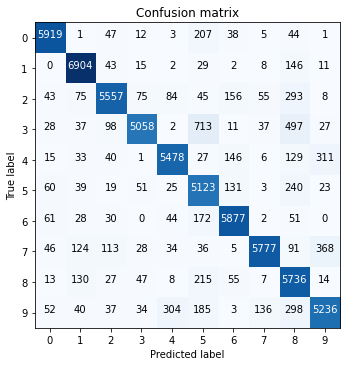

In [32]:
from sklearn.metrics import confusion_matrix
import itertools

cm = confusion_matrix(y_t,y_o)

classes = sorted(set(y_t)) # ['neg','pos'] 
tick_marks = np.arange(len(classes))

plt.figure(figsize=(5,5))

plt.xticks(tick_marks, classes) #, rotation=45)
plt.yticks(tick_marks, classes)
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)

plt.title('Confusion matrix')

# # plt.colorbar()


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [33]:
from sklearn.metrics import classification_report
print( classification_report( y_t, y_o ) )

              precision    recall  f1-score   support

           0       0.95      0.94      0.95      6277
           1       0.93      0.96      0.95      7160
           2       0.92      0.87      0.90      6391
           3       0.95      0.78      0.86      6508
           4       0.92      0.89      0.90      6186
           5       0.76      0.90      0.82      5714
           6       0.91      0.94      0.93      6265
           7       0.96      0.87      0.91      6622
           8       0.76      0.92      0.83      6252
           9       0.87      0.83      0.85      6325

    accuracy                           0.89     63700
   macro avg       0.89      0.89      0.89     63700
weighted avg       0.90      0.89      0.89     63700

